### Convert to networkx from dataframes

In [1]:
import networkx as nx
import pandas as pd 
import os
import pickle

# Create an undirected weighted graph
csv_dir = 'mind_adni1_bl/MIND_filtered_vertices/'
csv_list = os.listdir(csv_dir)
# for csv in csv_list:
#     if csv.endswith('.csv'):
#         adj_df = pd.read_csv(csv_dir + csv)
#         adj_df.index = adj_df.columns
#         G = nx.from_pandas_adjacency(adj_df)
#         # Save the graph
#         with open (csv_dir + 'nx/' + csv.replace('.csv', '.pickle'), 'wb') as f:
#             pickle.dump(G, f)
    # To load:
    # with open('mind_adni1_bl_tiny/graphs/' + csv.replace('.csv', '.pickle'), 'rb') as f:
    #     G_loaded = pickle.load(f)



### Graph2Vec

In [2]:
tadpole = pd.read_csv(r'C:\Users\efeka\Documents\GitHub\gnn-healthcare-thesis\imputation\TADPOLE_D1_D2_sorted_imputed.csv')

#### Thresholding function

In [3]:
import networkx as nx

def remove_low_weight_edges(graph, threshold, weight_attr='weight'):
    graph_copy = graph.copy()
    edges_to_remove = [(u, v) for u, v, d in graph_copy.edges(data=True)
                       if d.get(weight_attr, 0) < threshold]
    graph_copy.remove_edges_from(edges_to_remove)
    return graph_copy


#### PCA

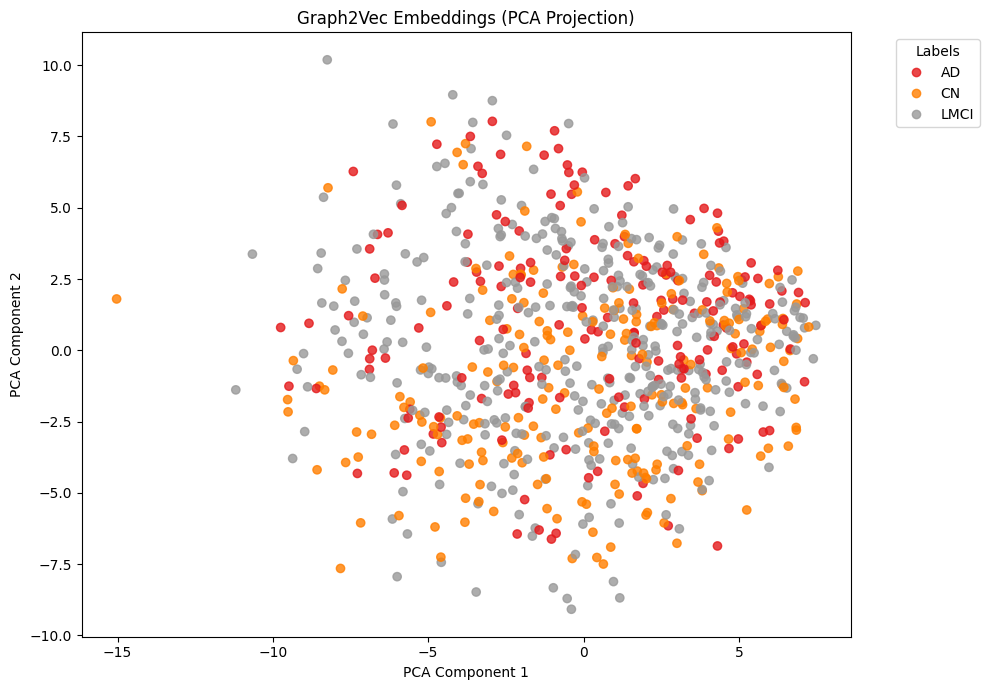

In [4]:
import os
import pickle
import numpy as np
import networkx as nx
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# --- Weisfeiler-Lehman feature extraction ---
def weisfeiler_lehman_step(graph, labels):
    new_labels = {}
    for node in graph.nodes():
        neighbors = sorted([labels[neighbor] for neighbor in graph.neighbors(node)])
        label_string = str(labels[node]) + "_" + "_".join(map(str, neighbors))
        new_labels[node] = hash(label_string)
    return new_labels

def extract_wl_features(graph, h=2):
    labels = {n: str(n) for n in graph.nodes()}
    doc = []

    for _ in range(h):
        labels = weisfeiler_lehman_step(graph, labels)
        doc.extend([str(v) for v in labels.values()])

    return doc

# --- Load graphs and labels ---
import pandas as pd

graph_list = []
label_list = []

apply_thresholding = True
threshold = 0.35 

graph_dir = csv_dir + 'nx/'
for fname in os.listdir(graph_dir):
    if fname.endswith('.pickle'):
        with open(os.path.join(graph_dir, fname), 'rb') as f:
            G = pickle.load(f)
            if apply_thresholding:
                graph_list.append(remove_low_weight_edges(G, threshold))
            else:
                graph_list.append(G)
            ptid = fname.replace('.pickle', '')
            label = tadpole[tadpole['PTID'] == ptid]['DX_bl'].values[0]
            label_list.append(label)

# --- Prepare documents for Doc2Vec ---
documents = [TaggedDocument(words=extract_wl_features(g, h=3), tags=[str(i)]) for i, g in enumerate(graph_list)]

# --- Train Doc2Vec (Graph2Vec) ---
model = Doc2Vec(vector_size=128, window=7, min_count=1, workers=4, epochs=50, dm=0)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

# --- Extract graph-level embeddings ---
graph_embeddings = np.array([model.dv[str(i)] for i in range(len(graph_list))])

# --- Optional: Scale before PCA ---
scaler = StandardScaler()
graph_embeddings_scaled = scaler.fit_transform(graph_embeddings)

# --- PCA Reduction ---
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(graph_embeddings_scaled)

# --- Encode labels ---
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_list)

# --- Plot ---
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=encoded_labels,
    cmap='Set1',
    alpha=0.8
)
handles, _ = scatter.legend_elements()
plt.legend(handles, label_encoder.classes_, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Graph2Vec Embeddings (PCA Projection)")
plt.tight_layout()
plt.show()


In [16]:
# print the distribution of node numbers in the graphs in graph_list
node_counts = [len(g.nodes()) for g in graph_list]
print("Node counts in graphs:")
print(node_counts)
print(np.unique(node_counts, return_counts=True))

Node counts in graphs:
[68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 

In [21]:
np.unique(label_list, return_counts=True)

(array(['AD', 'CN', 'LMCI'], dtype='<U4'), array([188, 225, 389], dtype=int64))

#### classifier

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# --- Parameters ---
use_class_weights = True  # Set to False if you don't want class weighting
use_logistic_regression = False  # Toggle between LogisticRegression and RandomForest
n_splits = 5  # Number of cross-validation folds

# --- Set classifier with or without class weights ---
def get_classifier():
    if use_logistic_regression:
        return LogisticRegression(max_iter=1000, penalty="l2",
                                  class_weight='balanced' if use_class_weights else None)
    else:
        return RandomForestClassifier(n_estimators=500, max_depth=3, random_state=42, max_features='sqrt',
                                      class_weight='balanced' if use_class_weights else None)

# --- Stratified K-Fold Cross Validation ---
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold = 1
all_val_preds = []
all_val_true = []

print(f"\n--- {n_splits}-Fold Cross-Validation ---")
for train_index, val_index in skf.split(graph_embeddings_scaled, encoded_labels):
    X_train, X_val = graph_embeddings_scaled[train_index], graph_embeddings_scaled[val_index]
    y_train, y_val = encoded_labels[train_index], encoded_labels[val_index]

    clf = get_classifier()
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)

    # print(f"\n--- Fold {fold} ---")
    # print("Training Metrics:")
    # print(classification_report(y_train, y_train_pred, target_names=label_encoder.classes_))
    # print("Validation Metrics:")
    # print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

    all_val_preds.extend(y_val_pred)
    all_val_true.extend(y_val)
    fold += 1

# --- Overall validation metrics across all folds ---
print("\n--- Overall Cross-Validation Metrics ---")
print("Classification Report (Validation):")
print(classification_report(all_val_true, all_val_preds, target_names=label_encoder.classes_))
print("Confusion Matrix (Validation):")
print(confusion_matrix(all_val_true, all_val_preds))



--- 5-Fold Cross-Validation ---

--- Overall Cross-Validation Metrics ---
Classification Report (Validation):
              precision    recall  f1-score   support

          AD       0.33      0.46      0.39       188
          CN       0.35      0.46      0.40       225
        LMCI       0.51      0.32      0.40       389

    accuracy                           0.40       802
   macro avg       0.40      0.42      0.39       802
weighted avg       0.43      0.40      0.40       802

Confusion Matrix (Validation):
[[ 87  48  53]
 [ 54 104  67]
 [122 141 126]]
